In [1]:
cd notebooks/

/home/nicit/deep_learning_course_wfco/notebooks


In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm import trange
import matplotlib.pyplot as plt

In [3]:
data = torch.load('../data/dataset_yaw_1000.pt')

X = data['X'].float()
Y = data['Y'].float()

print("Loaded X shape:", X.shape)
print("Loaded Y shape:", Y.shape)


Loaded X shape: torch.Size([185, 3960000])
Loaded Y shape: torch.Size([46, 3960000])


In [4]:
n_per_turbine = 4   # d_x, d_y, ws_eff, ti_eff
n_turbines = 46
cases_per_layout = 360*11
n_layouts = X.shape[1] // cases_per_layout
print(n_layouts)


1000


In [15]:
# --- Parameters ---
global_features = ['ws', 'aep']  # appended after per-turbine features

# --- Compute per-feature indices ---
# Order per turbine: d_x, d_y, ws_eff, ti_eff
ws_eff_idx = torch.tensor([n_per_turbine*i + 2 for i in range(n_turbines)])
ti_eff_idx = torch.tensor([n_per_turbine*i + 3 for i in range(n_turbines)])
global_idx = torch.tensor(n_turbines*n_per_turbine)  # ws, aep

# Global features: last rows
ws_idx  = torch.tensor([n_turbines * n_per_turbine + 0])
# aep_idx = torch.tensor([n_turbines * n_per_turbine + 1])

# Combine features to standardize: ws_eff, ti_eff, ws, aep
features_to_standardize = torch.cat([ws_eff_idx, ti_eff_idx, ws_idx]) #aep_idx

# --- Split dataset by layout (assuming already loaded as X, Y) ---
n_train_layouts = int(.6 * n_layouts)
n_val_layouts   = int(.2 * n_layouts)
n_test_layouts  = int(.2 * n_layouts)

train_start = 0
train_end   = n_train_layouts * cases_per_layout
val_start   = train_end
val_end     = val_start + n_val_layouts * cases_per_layout
test_start  = val_end
test_end    = test_start + n_test_layouts * cases_per_layout

X_train = X[:, train_start:train_end]
Y_train = Y[:, train_start:train_end]
X_val   = X[:, val_start:val_end]
Y_val   = Y[:, val_start:val_end]
X_test  = X[:, test_start:test_end]
Y_test  = Y[:, test_start:test_end]

In [16]:
# --- standardize ws_eff globally ---
all_ws_eff = X_train[ws_eff_idx, :].flatten()
mean_ws_eff = all_ws_eff.mean()
std_ws_eff  = all_ws_eff.std()
std_ws_eff = std_ws_eff if std_ws_eff>0 else 1.0
X_train[ws_eff_idx, :] = (X_train[ws_eff_idx, :] - mean_ws_eff) / std_ws_eff
X_val[ws_eff_idx, :]   = (X_val[ws_eff_idx, :]   - mean_ws_eff) / std_ws_eff
X_test[ws_eff_idx, :]  = (X_test[ws_eff_idx, :]  - mean_ws_eff) / std_ws_eff

# --- standardize ti_eff globally ---
all_ti_eff = X_train[ti_eff_idx, :].flatten()
mean_ti_eff = all_ti_eff.mean()
std_ti_eff  = all_ti_eff.std() 
std_ti_eff  = std_ti_eff if std_ti_eff>0 else 1.0
# Safe replacement of 0 std
# std_ti_eff = torch.where(std_ti_eff == 0, torch.tensor(1.0, device=std_ti_eff.device), std_ti_eff)

X_train[ti_eff_idx, :] = (X_train[ti_eff_idx, :] - mean_ti_eff) / std_ti_eff
X_val[ti_eff_idx, :]   = (X_val[ti_eff_idx, :]   - mean_ti_eff) / std_ti_eff
X_test[ti_eff_idx, :]  = (X_test[ti_eff_idx, :]  - mean_ti_eff) / std_ti_eff

# --- standardize global features together (ws, aep) ---
mean_global = X_train[global_idx, :].mean()
std_global  = X_train[global_idx, :].std()
std_global[std_global==0] = 1.0

X_train[global_idx, :] = (X_train[global_idx, :] - mean_global) / std_global
X_val[global_idx, :]   = (X_val[global_idx, :]   - mean_global) / std_global
X_test[global_idx, :]  = (X_test[global_idx, :]  - mean_global) / std_global

print("NaNs in TI eff: ", torch.isnan(X_train[ti_eff_idx, :]).sum())  # count of NaNs
print("NaN in WS eff", torch.isnan(X_train[ws_eff_idx, :]).sum())  # count of NaNs

print("Dataset shapes:")
print("Train:", X_train.shape, Y_train.shape)
print("Val:  ", X_val.shape,   Y_val.shape)
print("Test: ", X_test.shape,  Y_test.shape)

# --- standardize Y_train globally per output ---
mean_Y = Y_train.mean(dim=1, keepdim=True)   # shape: (n_outputs, 1)
std_Y  = Y_train.std(dim=1, keepdim=True)
std_Y[std_Y == 0] = 1.0  # safe replacement for zero std

Y_train = (Y_train - mean_Y) / std_Y
Y_val   = (Y_val   - mean_Y) / std_Y
Y_test  = (Y_test  - mean_Y) / std_Y

# Optional: check for NaNs
print("NaNs in Y_train:", torch.isnan(Y_train).sum())
print("NaNs in Y_val:",   torch.isnan(Y_val).sum())
print("NaNs in Y_test:",  torch.isnan(Y_test).sum())

NaNs in TI eff:  tensor(0)
NaN in WS eff tensor(0)
Dataset shapes:
Train: torch.Size([185, 2376000]) torch.Size([46, 2376000])
Val:   torch.Size([185, 792000]) torch.Size([46, 792000])
Test:  torch.Size([185, 792000]) torch.Size([46, 792000])
NaNs in Y_train: tensor(0)
NaNs in Y_val: tensor(0)
NaNs in Y_test: tensor(0)


In [17]:
# Before training:
X_train = X_train.T  # (n_samples, 185)
Y_train = Y_train.T  # (n_samples, 46)

X_val   = X_val.T
Y_val   = Y_val.T

In [25]:
import torch
import torch.nn as nn
from torch.nn import init

class YawRegressionNet(nn.Module):
    def __init__(self, n_inputs=185, hidden_layers=[512, 256, 128], n_outputs=46, negative_slope=0.01):
        super(YawRegressionNet, self).__init__()
        
        layers = []
        in_features = n_inputs
        
        for h in hidden_layers:
            # Linear layer
            linear = nn.Linear(in_features, h)
            init.xavier_normal_(linear.weight)
            init.constant_(linear.bias, 0.0)
            layers.append(linear)
            
            # BatchNorm
            layers.append(nn.BatchNorm1d(h))
            
            # LeakyReLU activation
            layers.append(nn.LeakyReLU(negative_slope=negative_slope))
            
            in_features = h
        
        # Output layer
        out_layer = nn.Linear(in_features, n_outputs)
        init.xavier_normal_(out_layer.weight)
        init.constant_(out_layer.bias, 0.0)
        layers.append(out_layer)
        
        # Combine into Sequential
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [30]:
from torch.utils.data import TensorDataset, DataLoader

# --- Hyperparameters ---
batch_size = 2048   # or 1024
n_epochs   = 10
learning_rate = 1e-3  # 6e-4

# --- DataLoaders for random batching ---
train_dataset = TensorDataset(X_train, Y_train)
val_dataset   = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- Metrics lists ---
train_mse, val_mse, train_rmse_deg = [], [], []
train_rmse, val_rmse, val_rmse_deg = [], [], []

# --- Device setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# --- Model, loss, optimizer ---
model = YawRegressionNet(n_inputs=185, hidden_layers=[512, 256, 128], n_outputs=46).to(device)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {n_params}")
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# --- Training loop ---
for epoch in trange(n_epochs, desc="Epochs"):
    # --- Training ---
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        y_pred = model(xb)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    mse_train = total_train_loss / len(train_loader)
    rmse_train = mse_train ** 0.5
    train_mse.append(mse_train)
    train_rmse.append(rmse_train)

    # --- Validation ---
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            y_val_pred = model(xb_val)
            loss_val = criterion(y_val_pred, yb_val)
            total_val_loss += loss_val.item()

    mse_val = total_val_loss / len(val_loader)
    rmse_val = mse_val ** 0.5
    val_mse.append(mse_val)
    val_rmse.append(rmse_val)

    # Convert training RMSE to degrees
    rmse_train_deg = (rmse_train * std_Y).mean().item()   # average across outputs
    train_rmse_deg.append(rmse_train_deg)

    # Convert validation RMSE to degrees
    rmse_val_deg = (rmse_val * std_Y).mean().item()
    val_rmse_deg.append(rmse_val_deg)
    

    # --- Logging ---
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs}: "
              f"Train MSE {mse_train:.6f}, RMSE {rmse_train:.6f}, RMSE (deg): {rmse_train_deg:.6f} | "
              f"Val MSE {mse_val:.6f}, RMSE {rmse_val:.6f}, RMSE (deg): {rmse_val_deg:.6f}")


Device: cuda
Total trainable parameters: 267182


Epochs:  10%|█         | 1/10 [00:41<06:17, 41.98s/it]

Epoch 1/10: Train MSE 1.002256, RMSE 1.001127, RMSE (deg): 7.623734 | Val MSE 0.975600, RMSE 0.987725, RMSE (deg): 7.521672


Epochs:  50%|█████     | 5/10 [03:30<03:30, 42.05s/it]

Epoch 5/10: Train MSE 0.975908, RMSE 0.987880, RMSE (deg): 7.522858 | Val MSE 1.000742, RMSE 1.000371, RMSE (deg): 7.617974


Epochs: 100%|██████████| 10/10 [07:00<00:00, 42.04s/it]

Epoch 10/10: Train MSE 0.952280, RMSE 0.975849, RMSE (deg): 7.431233 | Val MSE 1.020970, RMSE 1.010431, RMSE (deg): 7.694582


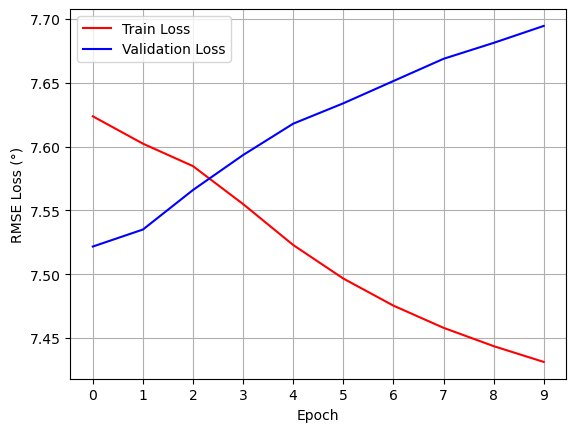

In [31]:
# Plot train/val loss
plt.figure()
plt.plot(train_rmse_deg, 'r', label='Train Loss')
plt.plot(val_rmse_deg, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss (°)')
plt.xticks(np.arange(0, n_epochs, step=max(1, n_epochs//10)))   # ensure xticks are int
plt.legend()
plt.grid()
plt.show()


In [11]:
print(Y_train.std(), Y_train.mean())


tensor(7.6152) tensor(0.0149)
